#CREACIÓN RANDOM FOREST REGRESSOR (MODELO DE INTELIGENCIA ARTIFICIAL)

####Predicción de Ratings de Películas usando IA
Mini proyecto en Databricks para predecir calificaciones de películas a partir de géneros y estadísticas de usuario/película.

####Objetivo
Predecir el rating que un usuario daría a una película usando un modelo de IA supervisado. 
Las features incluyen géneros de la película, promedio de rating del usuario y número de ratings.

##1 CARGAMOS LOS ARCHIVOS
####Dataset
Se utilizó el dataset **MovieLens ml-latest-small**, que contiene:
- `movies.csv`: información de las películas (title, genres, movieId)
- `ratings.csv`: información de ratings (userId, movieId, rating, timestamp)

##2 CREAMOS VISTAS TEMPORALES

In [0]:
%sql

CREATE OR REPLACE TEMP VIEW movies
USING CSV
OPTIONS (
  path "/Workspace/Users/janovazqueznaya@gmail.com/movies.csv",
  header "true",
  inferSchema "true"
)

In [0]:
%sql
#COMPROBAMOS LOS DATOS
SELECT *
FROM movies
LIMIT 10;

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [0]:
%sql
CREATE OR REPLACE TEMP VIEW ratings
USING CSV
OPTIONS (
  path "/Workspace/Users/janovazqueznaya@gmail.com/ratings.csv",
  header "true",
  inferSchema "true"
);

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW movie_ratings AS
SELECT r.userId,
       r.movieId,
       r.rating,
       r.timestamp,
       m.title,
       m.genres
FROM ratings r
JOIN movies m
ON r.movieId = m.movieId;

In [0]:
%sql
SELECT *
FROM movie_ratings
LIMIT 10;

userId,movieId,rating,timestamp,title,genres
1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


##3 GENRES=>CÓDIGO BINARIO

In [0]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Traemos los datos a un DataFrame de Pandas
df = spark.sql("SELECT * FROM movie_ratings").toPandas()

# Separar los géneros en listas
df['genres_list'] = df['genres'].apply(lambda x: x.split('|'))

# Crear columnas binarias para cada género (1 si 0 no)
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genres_list']),
                             columns=mlb.classes_,
                             index=df.index)

# Unimos al DataFrame original
df = pd.concat([df, genre_dummies], axis=1)

# Vemos cómo queda
df.head()

,userId,movieId,rating,timestamp,title,genres,genres_list,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"[Mystery, Thriller]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"[Crime, Mystery, Thriller]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


##4 FEATURES ADICIONALES

In [0]:
#FEATURES
import numpy as np

##Promedio de rating por usuario
user_avg = df.groupby('userId')['rating'].mean().reset_index()
user_avg.columns = ['userId', 'user_avg_rating']
df = df.merge(user_avg, on='userId', how='left')

##Número de ratings por usuario
user_count = df.groupby('userId')['rating'].count().reset_index()
user_count.columns = ['userId', 'user_rating_count']
df = df.merge(user_count, on='userId', how='left')

##Promedio de rating por película
movie_avg = df.groupby('movieId')['rating'].mean().reset_index()
movie_avg.columns = ['movieId', 'movie_avg_rating']
df = df.merge(movie_avg, on='movieId', how='left')

##Número de ratings por película
movie_count = df.groupby('movieId')['rating'].count().reset_index()
movie_count.columns = ['movieId', 'movie_rating_count']
df = df.merge(movie_count, on='movieId', how='left')

##Reemplazar posibles NaN por 0
df.fillna(0, inplace=True)

df.head()

,userId,movieId,rating,timestamp,title,genres,genres_list,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_avg_rating,user_rating_count,movie_avg_rating,movie_rating_count
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.366379,232,3.920930,215
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.366379,232,3.259615,52
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4.366379,232,3.946078,102
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"[Mystery, Thriller]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,4.366379,232,3.975369,203
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"[Crime, Mystery, Thriller]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,4.366379,232,4.237745,204


##5 ENTRENAMOS Y EVALUAMOS EL MODELO DE IA
Este modelo de IA, Random Forest Regressor, sirve para dividir los datos en conjunto de entrenamiento y conjunto de prueba, para evaluar el modelo sin sesgo.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Elegir features
genre_cols = [col for col in df.columns if col not in ['userId', 'movieId', 'title', 'genres', 'genres_list', 'rating', 'timestamp']]
X = df[genre_cols]
y = df['rating']

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecir y evaluar
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE del modelo: {rmse:.2f}")

RMSE del modelo: 0.82


####TABLA REAL VS PREDICCIÓN

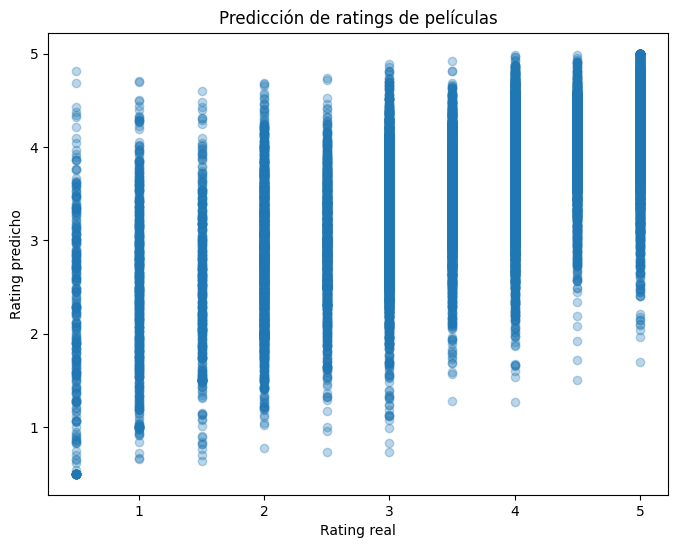

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel("Rating real")
plt.ylabel("Rating predicho")
plt.title("Predicción de ratings de películas")
plt.show()

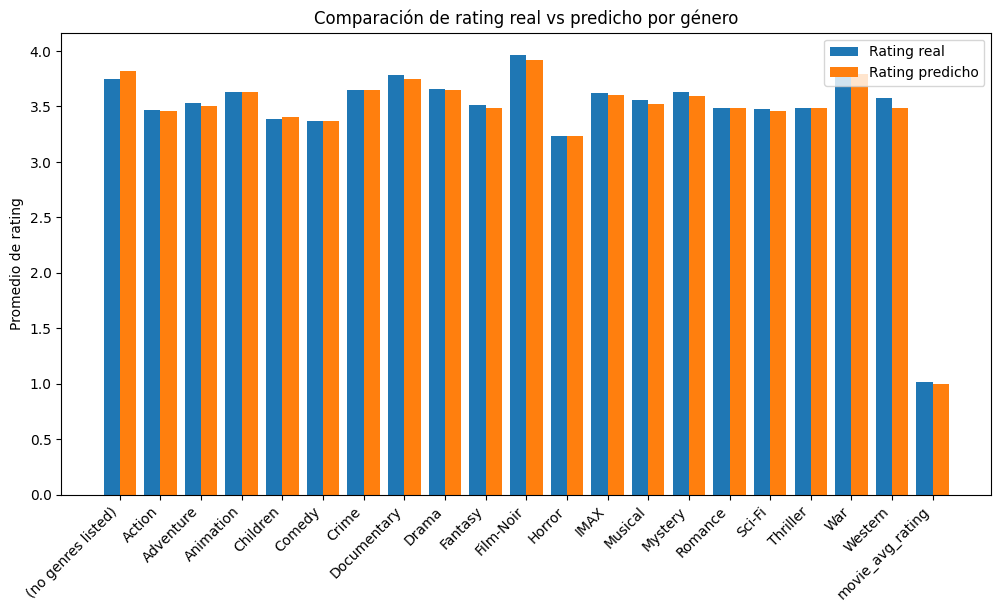

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Creamos un DataFrame con los resultados de test
df_results = X_test.copy()
df_results['rating_real'] = y_test.values
df_results['rating_pred'] = preds

# Creamos un diccionario para almacenar promedios por género
genre_cols = [col for col in X_test.columns if col not in ['user_avg_rating','user_rating_count','movie_rating_count']]

genre_avg = {'genre': [], 'real': [], 'pred': []}

for genre in genre_cols:
    # Filtramos las filas donde la película tiene el género
    genre_rows = df_results[df_results[genre] == 1]
    
    # Calculamos promedio real y predicho
    real_mean = genre_rows['rating_real'].mean()
    pred_mean = genre_rows['rating_pred'].mean()
    
    genre_avg['genre'].append(genre)
    genre_avg['real'].append(real_mean)
    genre_avg['pred'].append(pred_mean)

# Convertimos a DataFrame
df_genre_avg = pd.DataFrame(genre_avg)

# Gráfico de barras
x = range(len(df_genre_avg))
plt.figure(figsize=(12,6))
plt.bar(x, df_genre_avg['real'], width=0.4, label='Rating real', align='center')
plt.bar([i+0.4 for i in x], df_genre_avg['pred'], width=0.4, label='Rating predicho', align='center')
plt.xticks([i+0.2 for i in x], df_genre_avg['genre'], rotation=45, ha='right')
plt.ylabel('Promedio de rating')
plt.title('Comparación de rating real vs predicho por género')
plt.legend()
plt.show()

##6 CONCLUSIONES
Finalmente, después de utilizar el 80% de los datos para entrenar el modelo y el 20% para evaluarlo, el resultado es que el modelo tiene un RMSE (Root Mean Squared Error), que mide el error promedio de predicción de 0.82 en una escala de 0-5.

Esto demuestra que el modelo predice considerablemente bien los ratings, aunque teniendo en cuenta la cantidad de datos que se utilizaron para entrenar al modelo, el resultado podría haber sido bastante mejor.

MEJORAS: 